# Eval WEAC

Initialize models, run over a resolution of 5cm with a standardized weak layer.


In [2]:
# Auto reload modules
%load_ext autoreload
%autoreload all

In [ ]:
import os
from typing import List
import numpy as np
import pandas as pd
import copy
from tqdm.notebook import tqdm

from weac.analysis import CriteriaEvaluator, CoupledCriterionResult, SSERRResult
from weac.core.system_model import SystemModel
from weac.components import ModelInput, Segment, ScenarioConfig, WeakLayer, CriteriaConfig
from weac.utils.snowpilot_parser import SnowPilotParser

In [4]:
number_of_files = 100

# Process multiple files
file_paths = []
for directory in os.listdir("data/snowpits"):
    for file in os.listdir(f"data/snowpits/{directory}"):
        if file.endswith(".xml"):
            file_paths.append(f"data/snowpits/{directory}/{file}")

paths: List[str] = []
parsers: List[SnowPilotParser] = []

for file_path in file_paths[:number_of_files]:
    snowpilot_parser = SnowPilotParser(file_path)
    paths.append(file_path)
    parsers.append(snowpilot_parser)

print(f"\nFound {len(paths)} files")


Found 100 files


In [5]:
# Setup standard values
wl_spacing = 50 # mm
phi = 0.0
standard_scenario_config = ScenarioConfig(system_type="skier", phi=phi)
standard_weak_layer = WeakLayer(rho=125, h=20, E=1.0, sigma_c=6.16, tau_c=5.09)
standard_segments = [
    Segment(length=10000, has_foundation=True, m=0.0),
    Segment(
        length=10000,
        has_foundation=True,
        m=0.0,
    ),
]
standard_criteria_config = CriteriaConfig()
standard_criteria_evaluator = CriteriaEvaluator(standard_criteria_config)

In [6]:
import time
import weac

criteria_data_path = "data/criteria_data"
os.makedirs(criteria_data_path, exist_ok=True)

rerun = False
path = paths[0]
parser = parsers[0]

data_rows = []
# Extract layers
layers, density_method = parser.extract_layers()
print("layers: ", layers)
heights = np.cumsum([layer.h for layer in layers])
# space evenly and append the last height
wl_depths = np.arange(wl_spacing, heights[-1], wl_spacing).tolist()
wl_depths.append(heights[-1])

# Extract layers for plotting
plot_layers = layers
plot_weaklayer = standard_weak_layer

if rerun:
    layers_copy = copy.deepcopy(layers)
    for i, wl_depth in tqdm(enumerate(wl_depths), total=len(wl_depths), desc="Processing weak layers", leave=False):
        # only keep layers above the spacing
        mask = heights <= wl_depth
        new_layers = [layer for layer, keep in zip(layers_copy, mask) if keep]
        # Add truncated layer if needed
        depth = np.sum([layer.h for layer in new_layers]) if new_layers else 0.0
        if depth < wl_depth:
            additional_layer = copy.deepcopy(layers_copy[len(new_layers) if new_layers else 0])
            additional_layer.h = wl_depth - depth
            new_layers.append(additional_layer)
        
        if i >= len(wl_depths) - 2:
            print("new_layer heights: ", [layer.h for layer in new_layers])
            print("wl_depth: ", wl_depth)
            print("new_layers: ", new_layers)
        
        model_input = ModelInput(
            weak_layer=standard_weak_layer,
            layers=new_layers,
            scenario_config=standard_scenario_config,
            segments=standard_segments,
        )
        system = SystemModel(model_input=model_input)
        
        cc_result: CoupledCriterionResult = standard_criteria_evaluator.evaluate_coupled_criterion(system, print_call_stats=True)

        # Setup the scenario with the touchdown distance
        # TODO: Bug in Vertical SSERR
        time1 = time.time()
        sserr_result: SSERRResult = standard_criteria_evaluator.evaluate_SSERR(system, vertical=False)
        print("sserr_result: ", sserr_result)
        # sserr_result: SSERRResult = standard_criteria_evaluator.evaluate_SSERR(system, vertical=True)
        # time2 = time.time()
        # print("sserr_result: ", sserr_result)

        # print("\nwl_depth: ", wl_depth)
        # print("ImpactCriterion: ", cc_result.initial_critical_skier_weight)
        # print("CoupledCriterion: ", cc_result.critical_skier_weight)
        # print("Touchdown distance: ", sserr_result.touchdown_distance)
        # print("SSERR: ", sserr_result.SSERR)
        data_rows.append({
            "wl_depth": wl_depth,
            "impact_criterion": cc_result.initial_critical_skier_weight,
            "coupled_criterion": cc_result.critical_skier_weight,
            "sserr_result": sserr_result.SSERR,
            "touchdown_distance": sserr_result.touchdown_distance,
        })

    df = pd.DataFrame(data_rows)
    df.to_csv(os.path.join(criteria_data_path, os.path.basename(file_path)), index=False)

layers:  [Layer(rho=101.0, h=100.0, nu=0.25, E=0.3963944665536936, G=0.15855778662147743, tensile_strength=1.103877672602255, tensile_strength_method='sigrist', E_method='bergfeld', grain_type='DF', grain_size=None, hand_hardness='F'), Layer(rho=173.0, h=170.0, nu=0.25, E=4.231714820461142, G=1.6926859281844568, tensile_strength=4.1040183019389715, tensile_strength_method='sigrist', E_method='bergfeld', grain_type='DF', grain_size=None, hand_hardness='1F'), Layer(rho=137.0, h=30.0, nu=0.25, E=1.515947056821604, G=0.6063788227286416, tensile_strength=2.3226029915382136, tensile_strength_method='sigrist', E_method='bergfeld', grain_type='DF', grain_size=None, hand_hardness='4F'), Layer(rho=209.0, h=300.0, nu=0.25, E=9.722035388607377, G=3.888814155442951, tensile_strength=6.509291720550219, tensile_strength_method='sigrist', E_method='bergfeld', grain_type='DF', grain_size=None, hand_hardness='P'), Layer(rho=163.7, h=20.0, nu=0.25, E=3.318392308727041, G=1.3273569234908165, tensile_stren

In [7]:
from plotly_snow_profile import snow_profile
import pandas as pd

if not rerun:
    dataframe = pd.read_csv("data/criteria_data/snowpits-24461-caaml.csv")
else:
    dataframe = df

snow_profile_fig = snow_profile(weaklayer=plot_weaklayer, layers=plot_layers)
snow_profile_fig.show()


In [8]:
from plotly_snow_profile import criticality_plots

crit_plots_fig = criticality_plots(plot_weaklayer, plot_layers, dataframe)
crit_plots_fig.show()

In [9]:
from plotly_snow_profile import criticality_heatmap

crit_hm_fig = criticality_heatmap(plot_weaklayer, plot_layers, dataframe)
crit_hm_fig.show()

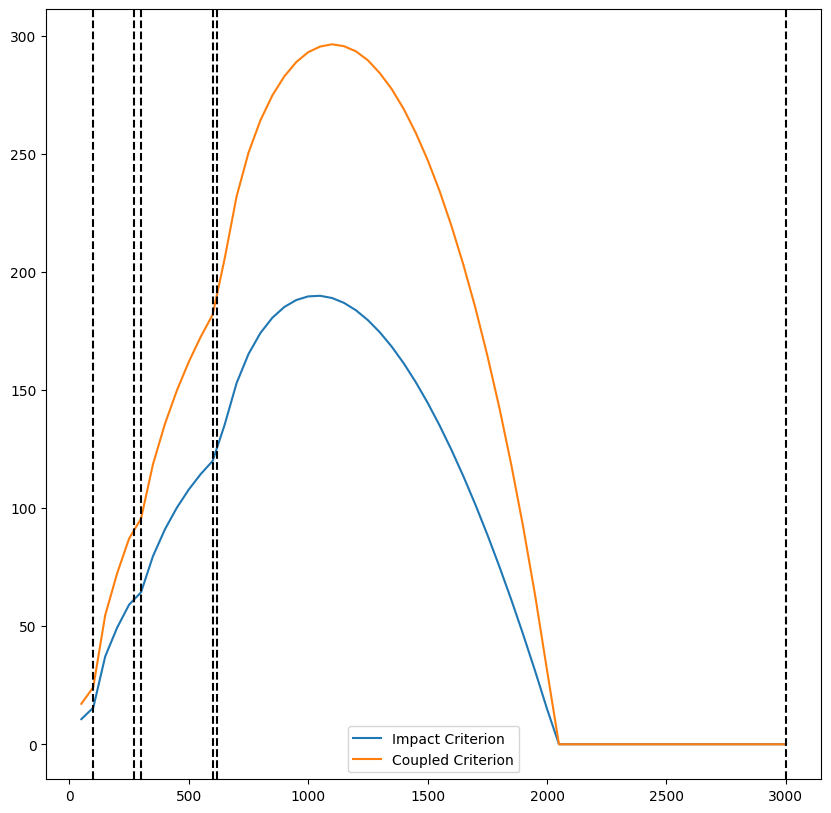

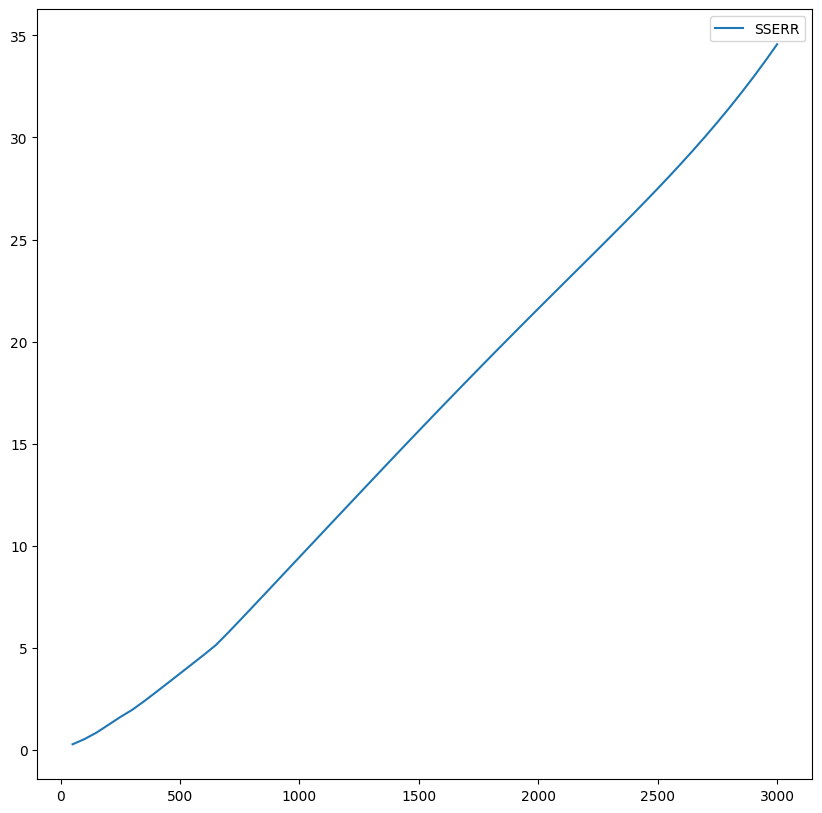

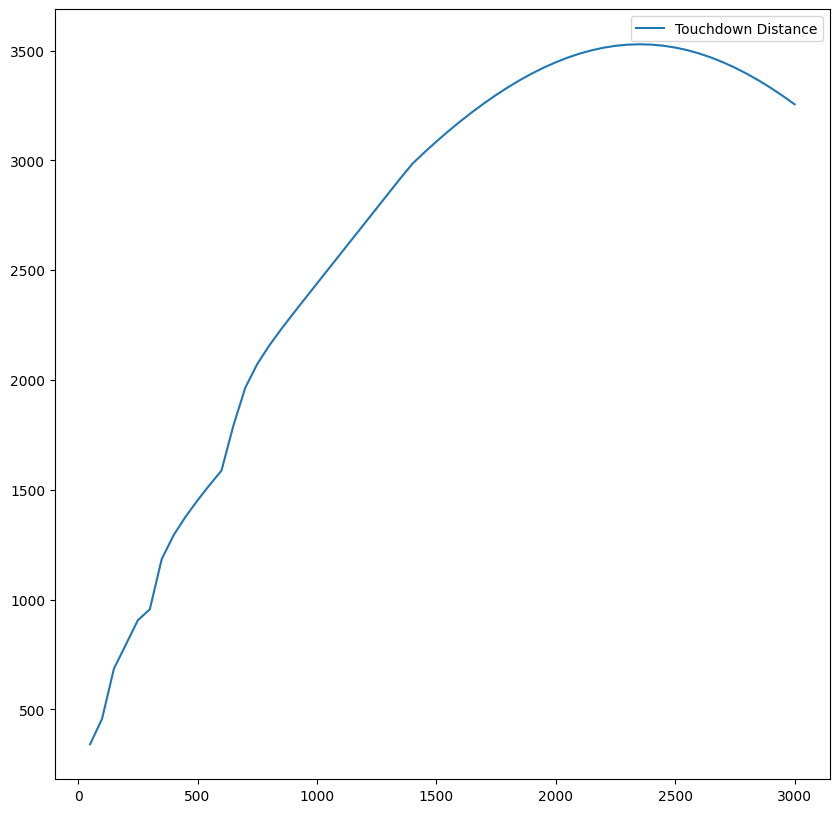

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(dataframe["wl_depth"], dataframe["impact_criterion"], label="Impact Criterion")
plt.plot(dataframe["wl_depth"], dataframe["coupled_criterion"], label="Coupled Criterion")
# plot vertical lines at the end of each layer
for i, height in enumerate(heights):
    plt.axvline(x=height, color="black", linestyle="--")
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(dataframe["wl_depth"], dataframe["sserr_result"], label="SSERR")
# plt.ylim(0, 4000)
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(dataframe["wl_depth"], dataframe["touchdown_distance"], label="Touchdown Distance")
plt.legend()
plt.show()

In [11]:
from PIL import Image
from io import BytesIO

figures = [crit_plots_fig, snow_profile_fig, crit_hm_fig]

images = []
for fig in figures:
    width = fig.layout.width*2
    height = fig.layout.height*2
    img_bytes = fig.to_image(format="png", width=width, height=height, scale=2)
    image = Image.open(BytesIO(img_bytes))
    images.append(image)

total_width = sum(im.width for im in images)
max_height = max(im.height for im in images)
combined = Image.new("RGB", (total_width, max_height), color=(255, 255, 255))
x_offset = 0
for im in images:
    combined.paste(im, (x_offset, 0))
    x_offset += im.width

combined.save("plots/combined.png")

In [12]:
def eval_weac_over_layers(parser: SnowPilotParser, scenario_config: ScenarioConfig, segments: list[Segment], weaklayer: WeakLayer, wl_spacing=100):
    data_rows = []
    # Extract layers
    layers, density_method = parser.extract_layers()
    heights = np.cumsum([layer.h for layer in layers])
    # space evenly and append the last height
    wl_depths = np.arange(wl_spacing, heights[-1], wl_spacing).tolist()
    wl_depths.append(heights[-1])
    
    layers_copy = copy.deepcopy(layers)
    for i, wl_depth in tqdm(enumerate(wl_depths), total=len(wl_depths), desc="Processing weak layers", leave=False):
        # only keep layers above the spacing
        mask = heights <= wl_depth
        new_layers = [layer for layer, keep in zip(layers_copy, mask) if keep]
        # Add truncated layer if needed
        depth = np.sum([layer.h for layer in new_layers]) if new_layers else 0.0
        if depth < wl_depth:
            additional_layer = copy.deepcopy(layers_copy[len(new_layers) if new_layers else 0])
            additional_layer.h = wl_depth - depth
            new_layers.append(additional_layer)
        
        model_input = ModelInput(
            weak_layer=weaklayer,
            layers=new_layers,
            scenario_config=scenario_config,
            segments=segments,
        )
        system = SystemModel(model_input=model_input)
        
        cc_result: CoupledCriterionResult = standard_criteria_evaluator.evaluate_coupled_criterion(system, print_call_stats=False)
        sserr_result: SSERRResult = standard_criteria_evaluator.evaluate_SSERR(system, vertical=False, print_call_stats=False)

        data_rows.append({
            "wl_depth": wl_depth,
            "impact_criterion": cc_result.initial_critical_skier_weight,
            "coupled_criterion": cc_result.critical_skier_weight,
            "sserr_result": sserr_result.SSERR,
            "touchdown_distance": sserr_result.touchdown_distance,
        })
    return data_rows, layers, weaklayer

In [13]:
from PIL import Image
from io import BytesIO
import plotly.graph_objects as go

def combine_plots(file_path: str, name: str, figures: list[go.Figure]):

    images = []
    for fig in figures:
        width = fig.layout.width*2
        height = fig.layout.height*2
        img_bytes = fig.to_image(format="png", width=width, height=height, scale=2)
        image = Image.open(BytesIO(img_bytes))
        images.append(image)

    total_width = sum(im.width for im in images)
    max_height = max(im.height for im in images)
    combined = Image.new("RGB", (total_width, max_height), color=(255, 255, 255))
    x_offset = 0
    for im in images:
        combined.paste(im, (x_offset, 0))
        x_offset += im.width

    combined.save(f"{file_path}/{name}.png")

In [14]:
import os

# Setup standard values
wl_spacing = 50 # mm
phi = 0.0
standard_scenario_config = ScenarioConfig(system_type="skier", phi=phi)
standard_weak_layer = WeakLayer(rho=125, h=20, E=1.0, sigma_c=5.16, tau_c=4.09)
standard_segments = [
    Segment(length=10000, has_foundation=True, m=0.0),
    Segment(
        length=10000,
        has_foundation=True,
        m=0.0,
    ),
]
standard_criteria_config = CriteriaConfig()
standard_criteria_evaluator = CriteriaEvaluator(standard_criteria_config)

scenario_config = standard_scenario_config
segments = standard_segments
weaklayer = standard_weak_layer

plots_path = "plots"
criteria_data_path = "data/criteria_data"
os.makedirs(criteria_data_path, exist_ok=True)

error_paths = []
for i, (file_path, parser) in tqdm(
    enumerate(zip(paths, parsers)), total=len(paths), desc="Processing files"
):  
    try:
        data_rows, layers, weaklayer = eval_weac_over_layers(parser, scenario_config, segments, weaklayer, wl_spacing=wl_spacing)
        dataframe = pd.DataFrame(data_rows)
        snow_profile_fig = snow_profile(weaklayer=weaklayer, layers=layers)
        crit_plots_fig = criticality_plots(weaklayer, layers, dataframe)
        crit_hm_fig = criticality_heatmap(weaklayer, layers, dataframe)
        combine_plots(plots_path, os.path.basename(file_path), [crit_plots_fig, snow_profile_fig, crit_hm_fig])
        base, _ = os.path.splitext(os.path.basename(file_path))
        dataframe.to_csv(os.path.join(criteria_data_path, base + ".csv"), index=False)
    except Exception as e:
        error_paths.append(file_path)
        print(f"Error processing file {file_path}: {e}")
        continue

print(f"Amount of errors: {len(error_paths)}")
print("Processed files: ", len(paths) - len(error_paths))

Processing files:   0%|          | 0/100 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/60 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/22 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/18 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/10 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/11 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/14 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/15 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/26 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/32 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/48 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/28 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/24 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/12 [00:00<?, ?it/s]

Error processing file data/snowpits/2019-2020/snowpits-20748-caaml.xml: Layer is missing density information; density profile, hand hardness and grain type are all missing. Excluding SnowPit from calculations.


Processing weak layers:   0%|          | 0/30 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/18 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/32 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/21 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/15 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/31 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/22 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/19 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/29 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/24 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/23 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/3 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/14 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/40 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/10 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/33 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/21 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/26 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/33 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/19 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/27 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/25 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/15 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/25 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/30 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/36 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/17 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/29 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/21 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/11 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/23 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/13 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/25 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/26 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Error processing file data/snowpits/2019-2020/snowpits-21005-caaml.xml: Layer is missing density information; density profile, hand hardness and grain type are all missing. Excluding SnowPit from calculations.


Processing weak layers:   0%|          | 0/26 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/13 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/17 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/24 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/29 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/35 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/50 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/6 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/18 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/17 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/35 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/26 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/21 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/26 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/17 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/32 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/19 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/18 [00:00<?, ?it/s]

Error processing file data/snowpits/2019-2020/snowpits-20094-caaml.xml: Layer is missing density information; density profile, hand hardness and grain type are all missing. Excluding SnowPit from calculations.


Processing weak layers:   0%|          | 0/16 [00:00<?, ?it/s]

Error processing file data/snowpits/2019-2020/snowpits-24828-caaml.xml: Layer is missing density information; density profile, hand hardness and grain type are all missing. Excluding SnowPit from calculations.


Processing weak layers:   0%|          | 0/14 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/22 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/24 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/22 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/27 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/38 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/18 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/15 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/11 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/15 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/44 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/30 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/24 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/12 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/27 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/19 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/20 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/27 [00:00<?, ?it/s]

Amount of errors: 4
Processed files:  96
